# 02.21.01 - DNN MFCC20 (4-Fold) SIGMOID

## Goals

In this experiment, we intend to assess the generalization capability of a Dense Neural Network using MFCC coeffecicients as features, through a 4-folds cross validation over the hive axis.

In reality, due to the fact that some hives in the reference dataset only present one label value (either queen of noqueen) a fold may be an agregate of 2 distincts hives, but in any case, for each fold, the network is tested over samples belonging to hive(s) it was never trained on. 

Distribution details are provided below:

<table border="1" class="dataframe" align="left">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>fold</th>
      <th>hive</th>
      <th>queen</th>
      <th>count(*)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>CF001</td>
      <td>0.0</td>
      <td>14</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>CF003</td>
      <td>1.0</td>
      <td>3649</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2</td>
      <td>CJ001</td>
      <td>0.0</td>
      <td>790</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2</td>
      <td>GH001</td>
      <td>1.0</td>
      <td>1396</td>
    </tr>
    <tr>
      <th>4</th>
      <td>3</td>
      <td>Hive1</td>
      <td>0.0</td>
      <td>1473</td>
    </tr>
    <tr>
      <th>5</th>
      <td>3</td>
      <td>Hive1</td>
      <td>1.0</td>
      <td>2684</td>
    </tr>
    <tr>
      <th>6</th>
      <td>4</td>
      <td>Hive3</td>
      <td>0.0</td>
      <td>6545</td>
    </tr>
    <tr>
      <th>7</th>
      <td>4</td>
      <td>Hive3</td>
      <td>1.0</td>
      <td>654</td>
    </tr>
  </tbody>
</table>
<br><br><br><br><br><br><br><br><br><br><br><br><br>



The network demonstrates extremely poor generalization, regardless of the topology or hyper-parameters we have tested so far.


## Prerequisites

- The dataset exists (if not, execute 02.00.01
- The dataset features have been populated (if not, execute 02.00.02)


<hr style="border:1px solid gray"></hr>

### Step 1: Get previously created dataset

In [48]:
import warnings                      # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')    # commented out till the experiment final version,
                                     # in order to avoid missing "real" warnings 

import kilroy_was_here               # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import (
    iprint,                          # timestamped (to the ms) print with CPU and RAM consumption information  
    predestination,                  # Seeds various PRNGs for reproducibility
    say_my_name                      # gets notebook name
)

from audace.audiodataset import AudioDataset      # Main class for audio dataset handling

from IPython.display import display

#########################
# Experiment parameters #
#########################

EXP_NAME = say_my_name()  # Experiment name will be used to create outputs directory

DATASET_NAME = 'MAIN1000' # Dataset name is the master key for dataset addressing
                          # Change it according to the dataset you want to process

FEATURE_NAME = 'mfcc20'   # Name of the feature used for classification
LABEL_NAME = 'queen'      # Name of the label used for classification
FOLD_NAME = 'fold'        # Column nam of the fold axis
VALID_FRAC = 0.3          # Fraction of the training set used for validation (NOT TESTING)
                          # This is used to drive early stopping. Hyperparameters may be tuned
                          # over the validation set, but the test set is kept isolated to avoid biases.


# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Build dataframe containing all the information needed to conduct the experiment
sql = F"SELECT {FEATURE_NAME}, {LABEL_NAME}, {FOLD_NAME} FROM samples WHERE nobee = 0"
df = ds.queryDataFrame(sql)

# Display detailed cardinalities
print("\n====== CARDINALITIES ======")
sql = """
    select distinct fold, hive, queen, count(*)
    from samples
    where nobee = 0
    group by fold, queen
    order by fold, queen
    """
display(ds.queryDataFrame(sql))

# display distribution per fold
print("\n======  PER FOLD QUEEN/NOQUEEN DISTRIBUTION ======")
sql = """
    select distinct fold,
    count(case queen when 1.0 then 1 else null end) as Q,
    count(case queen when 0.0 then 1 else null end) as NQ,
    round(100.0*count(case queen when 1.0 then 1 else null end)/count(*), 2)  as Q_ratio
    from samples
    where nobee = 0
    group by fold
    order by fold
    """
display(ds.queryDataFrame(sql))


# display global distribution
print("\n======  GLOBAL QUEEN/NOQUEEN DISTRIBUTION ======")
sql = """
    select
    count(case queen when 1.0 then 1 else null end) as Q,
    count(case queen when 0.0 then 1 else null end) as NQ,
    round(100.0*count(case queen when 1.0 then 1 else null end)/count(*), 2)  as Q_ratio
    from samples
    where nobee = 0
    """
display(ds.queryDataFrame(sql))

[2020-09-07/11:27:49.226|05.8%|76.0%|0.25GB] ------------------------------------------------------
[2020-09-07/11:27:49.226|00.0%|76.0%|0.25GB] DATASET NAME          : MAIN1000
[2020-09-07/11:27:49.227|00.0%|76.0%|0.25GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-09-07/11:27:49.228|00.0%|76.0%|0.25GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-09-07/11:27:49.228|00.0%|76.0%|0.25GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-09-07/11:27:49.228|00.0%|76.0%|0.25GB] NB SOURCE AUDIO FILES : 48
[2020-09-07/11:27:49.228|00.0%|76.0%|0.25GB] SAMPLE RATE           : 22050
[2020-09-07/11:27:49.229|00.0%|76.0%|0.25GB] DURATION              : 1.0
[2020-09-07/11:27:49.229|00.0%|76.0%|0.25GB] OVERLAP               : 0.0
[2020-09-07/11:27:49.229|00.0%|76.0%|0.25GB] NB AUDIO CHUNKS       : 24788
[2020-09-07/11:27:49.229|00.0%|76.0%|0.25GB] ------------------------------------------------------

====== CARDI

,fold,hive,queen,count(*)
0,1,CF001,0.0,14
1,1,CF003,1.0,3649
2,2,CJ001,0.0,790
3,2,GH001,1.0,1396
4,3,Hive1,0.0,1473
5,3,Hive1,1.0,2684
6,4,Hive3,0.0,6545
7,4,Hive3,1.0,654



======  PER FOLD QUEEN/NOQUEEN DISTRIBUTION ======


,fold,Q,NQ,Q_ratio
0,1,3649,14,99.62
1,2,1396,790,63.86
2,3,2684,1473,64.57
3,4,654,6545,9.08



======  GLOBAL QUEEN/NOQUEEN DISTRIBUTION ======


,Q,NQ,Q_ratio
0,8383,8822,48.72


<hr style="border:1px solid gray"></hr>

### Step 2: Process DNN learning

In [2]:
from tensorflow import keras

def nn(n_inputs):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=n_inputs))
    model.add(keras.layers.Dense(4, activation="selu", kernel_initializer="lecun_normal"))
    model.add(keras.layers.Dense(8, activation="selu", kernel_initializer="lecun_normal"))
    model.add(keras.layers.Dense(4, activation="selu", kernel_initializer="lecun_normal"))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy", optimizer="nadam",
        metrics=[
            "accuracy"
        ]
    )    
    
    return model

In [10]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from audace.splitters import splitTrainValidTestFold

# Seed the various PRNGs
predestination()

histories = []
X_tests = []
y_tests = []
models = []

# Iterate over folds
for fold in ds.listAttributeValues(FOLD_NAME):
    print(F"############### FOLD {fold} ###############")
    # Build training and test datasets
    iprint(">>>>> Building partitions training/test")
    X_train, X_valid, X_test, y_train, y_valid, y_test = splitTrainValidTestFold(
        df,
        FEATURE_NAME,
        LABEL_NAME,
        FOLD_NAME,
        fold,
        VALID_FRAC
    )
      
    # Standardize data 
    iprint(">>>>> Standardize")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)

    # Build NN
    iprint(">>>>> Build NN")
    keras.backend.clear_session()
    model = nn(X_train[0].shape)

    iprint(F">>>>> Train on {len(X_train)}, valid on {len(X_valid)}, test on {len(X_test)}")
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_valid, y_valid),
                        epochs=100,
                        callbacks=[early_stopping_cb],
                        verbose=2
    )
    
    #Store data (will be used later for reporting)
    histories.append(history)
    X_tests.append(X_test)
    y_tests.append(y_test)
    models.append(model)


############### FOLD 1 ###############
[2020-09-07/10:35:08.338|05.6%|85.9%|0.59GB] >>>>> Building partitions training/test
[2020-09-07/10:35:08.433|22.4%|86.2%|0.61GB] >>>>> Standardize
[2020-09-07/10:35:08.669|24.8%|86.1%|0.61GB] >>>>> Build NN
[2020-09-07/10:35:08.753|27.5%|86.2%|0.61GB] >>>>> Train on 9479, valid on 4063, test on 3663
Train on 9479 samples, validate on 4063 samples
Epoch 1/100
9479/9479 - 2s - loss: 0.1175 - accuracy: 0.9592 - val_loss: 0.0361 - val_accuracy: 0.9906
Epoch 2/100
9479/9479 - 0s - loss: 0.0202 - accuracy: 0.9951 - val_loss: 0.0228 - val_accuracy: 0.9943
Epoch 3/100
9479/9479 - 0s - loss: 0.0087 - accuracy: 0.9982 - val_loss: 0.0226 - val_accuracy: 0.9941
Epoch 4/100
9479/9479 - 0s - loss: 0.0060 - accuracy: 0.9985 - val_loss: 0.0224 - val_accuracy: 0.9938
Epoch 5/100
9479/9479 - 0s - loss: 0.0027 - accuracy: 0.9999 - val_loss: 0.0186 - val_accuracy: 0.9943
Epoch 6/100
9479/9479 - 0s - loss: 0.0019 - accuracy: 0.9999 - val_loss: 0.0190 - val_accuracy: 

<hr style="border:1px solid gray"></hr>

### Step 3: Display learning report

[2020-09-07/10:36:02.158|10.0%|86.2%|0.62GB] ========== FOLD 1 ==========


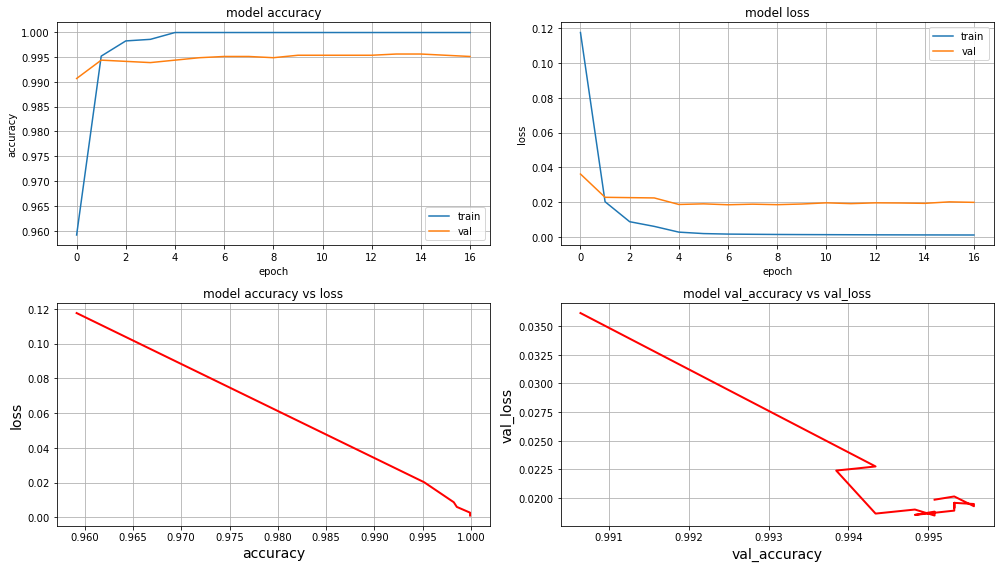

[2020-09-07/10:36:03.442|13.9%|86.3%|0.62GB] ========== FOLD 2 ==========


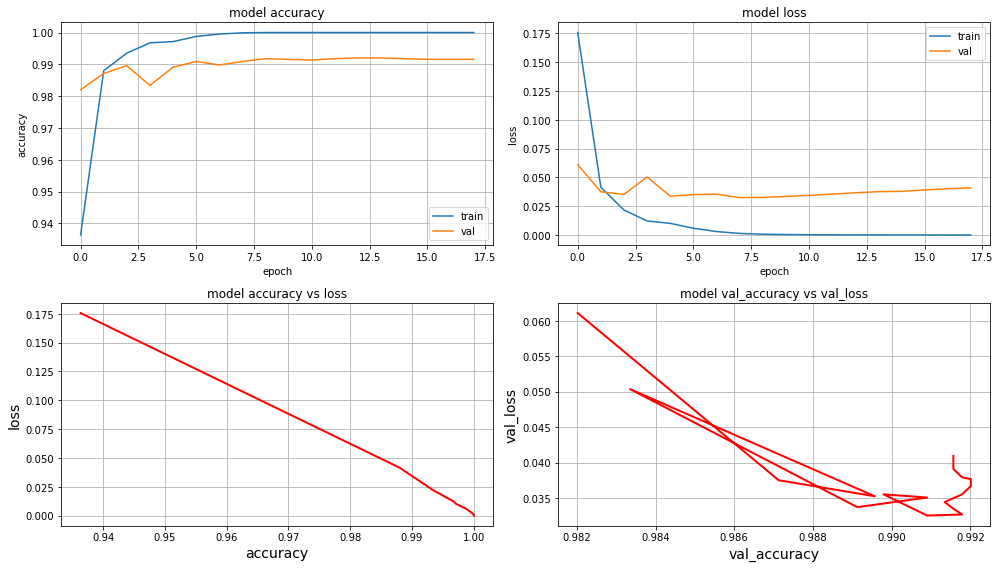

[2020-09-07/10:36:04.887|25.2%|84.9%|0.62GB] ========== FOLD 3 ==========


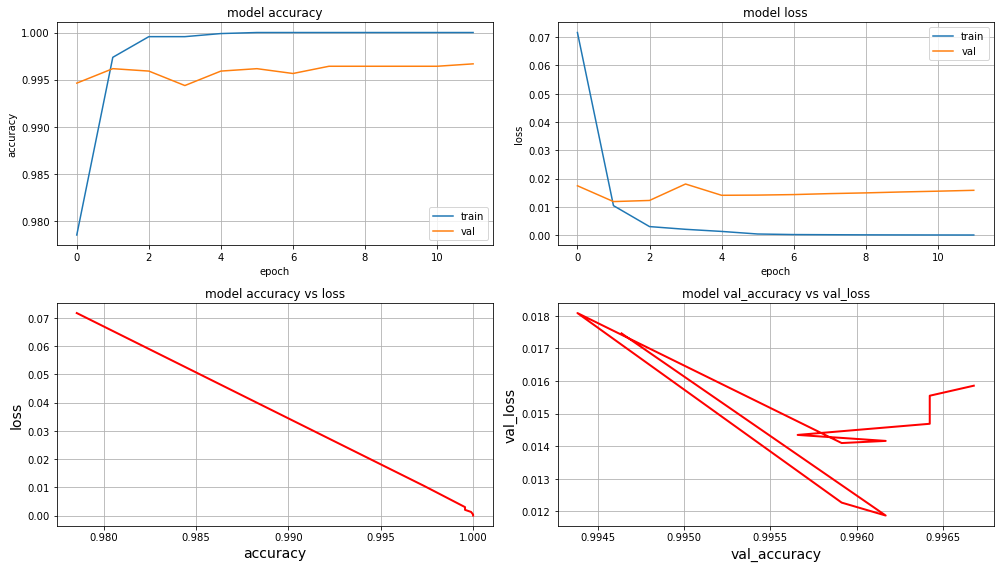

[2020-09-07/10:36:06.074|17.6%|85.0%|0.63GB] ========== FOLD 4 ==========


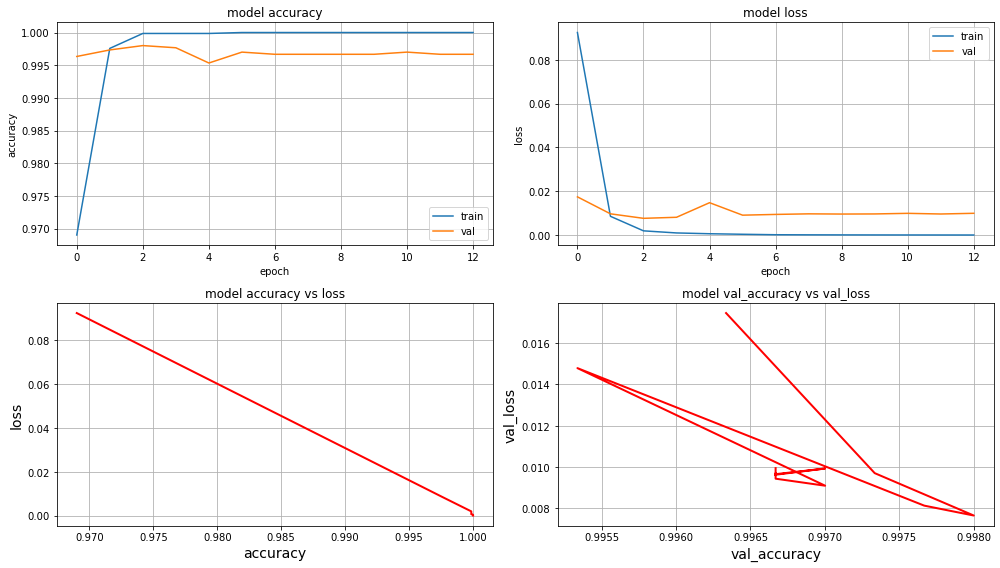

In [11]:
from audace.plotters import plot_nn_learning_curves

for i, fold in enumerate(ds.listAttributeValues(FOLD_NAME)):
    iprint(F"========== FOLD {fold} ==========")
    plot_nn_learning_curves(histories[i], EXP_NAME, 'learning report fold ' + str(fold))

<hr style="border:1px solid gray"></hr>

### Step 4 : Display performance reports

[2020-09-07/10:36:15.622|07.1%|85.7%|0.63GB] ========== FOLD 1 ==========


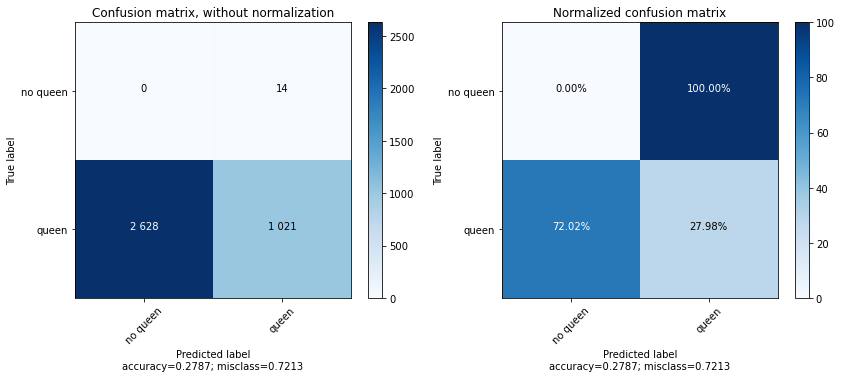

[2020-09-07/10:36:16.017|19.0%|85.9%|0.64GB] >>>>> Predict
[2020-09-07/10:36:16.120|35.4%|85.9%|0.64GB] loss: 5.764019357549536
[2020-09-07/10:36:16.121|16.7%|85.9%|0.64GB] accuracy: 0.2787332832813263
[2020-09-07/10:36:16.337|17.9%|85.9%|0.64GB] ans: 1.0 / acc: 0.25517432976802334
[2020-09-07/10:36:16.338|00.0%|85.9%|0.64GB] ========== FOLD 2 ==========


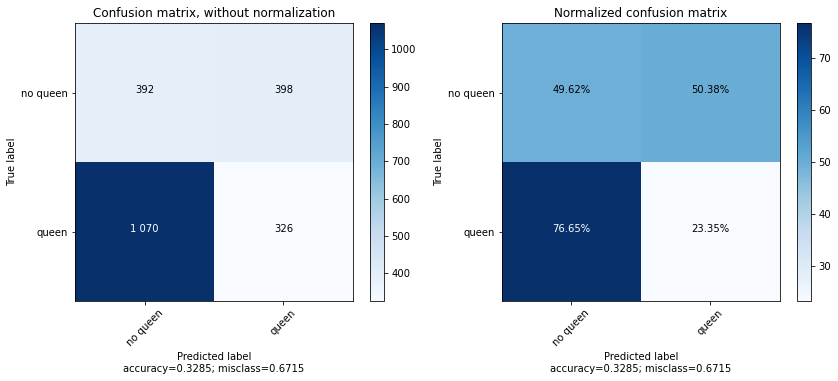

[2020-09-07/10:36:16.880|14.3%|84.5%|0.59GB] >>>>> Predict
[2020-09-07/10:36:16.957|14.6%|84.5%|0.59GB] loss: 3.0875917486607865
[2020-09-07/10:36:16.958|00.0%|84.5%|0.59GB] accuracy: 0.32845380902290344
[2020-09-07/10:36:17.144|19.8%|84.5%|0.59GB] ans: 1.0 / acc: 0.25517432976802334
[2020-09-07/10:36:17.144|00.0%|84.5%|0.59GB] ========== FOLD 3 ==========


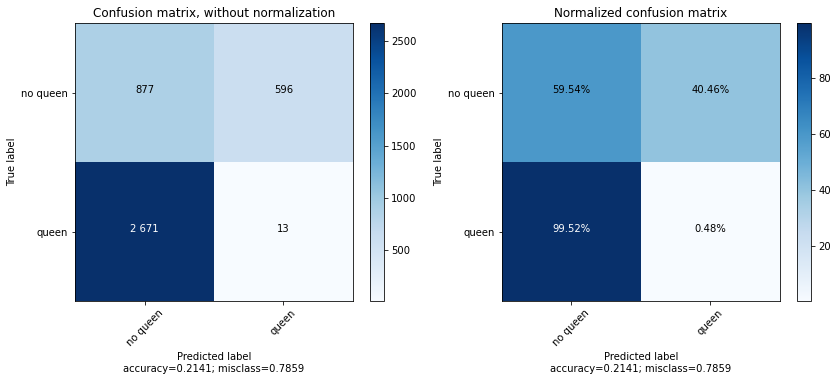

[2020-09-07/10:36:17.501|16.9%|84.5%|0.59GB] >>>>> Predict
[2020-09-07/10:36:17.616|30.0%|84.5%|0.59GB] loss: 5.9394645059957565
[2020-09-07/10:36:17.616|00.0%|84.5%|0.59GB] accuracy: 0.21409671008586884
[2020-09-07/10:36:17.805|21.1%|84.5%|0.59GB] ans: 1.0 / acc: 0.25517432976802334
[2020-09-07/10:36:17.805|00.0%|84.5%|0.59GB] ========== FOLD 4 ==========


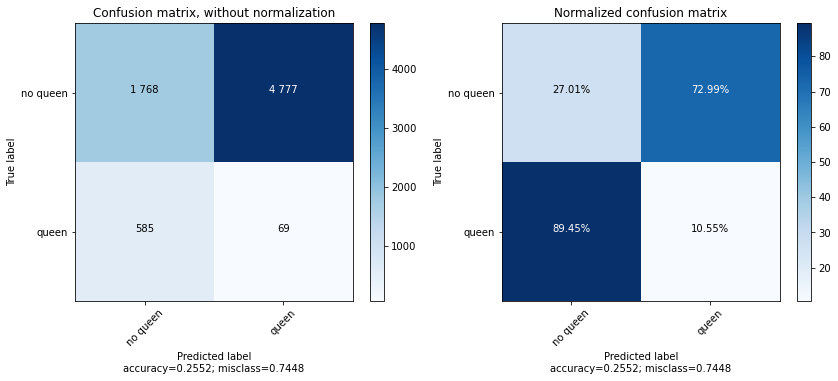

[2020-09-07/10:36:18.200|12.9%|84.5%|0.59GB] >>>>> Predict
[2020-09-07/10:36:18.365|20.0%|84.5%|0.59GB] loss: 9.254441756790818
[2020-09-07/10:36:18.365|00.0%|84.5%|0.59GB] accuracy: 0.25517433881759644
[2020-09-07/10:36:18.554|18.9%|84.5%|0.59GB] ans: 1.0 / acc: 0.25517432976802334


In [12]:
from audace.plotters import nn_full_report
from audace.metrics import i_may_be_wrong

for i, fold in enumerate(ds.listAttributeValues(FOLD_NAME)):
    iprint(F"========== FOLD {fold} ==========")
    nn_full_report(models[i], X_tests[i], y_tests[i], target_names = ['no queen', 'queen'])

    #Predict the response for test dataset
    iprint('>>>>> Predict')
    scores = models[i].evaluate(X_tests[i], y_tests[i], verbose=0)

    for j in range(len(scores)):
        iprint(F"{models[i].metrics_names[j]}: {scores[j]}")
        
        
    ans, acc = i_may_be_wrong(model, X_test, y_test, 0.01, 0.99)
    iprint(F"ans: {ans} / acc: {acc}")